# Furry Image Model Notebook

Hello! This is my Jupyter Notebook explaining how my furry image model works. Here, I will describe some basic usage and intuition behind this project for those who would like a quickstart to using it. Go ahead and click "Run All"/"Restart and Run All" for this Jupyter Notebook, as the sections are meant to be viewed in sequential order.


**Make sure you have downloaded a model to use for inference. You can find them in the Model List in the README**

### Imports

For the most part, all the imports are straightforward. They are used for loading sample date, running helper functions, and visualizing examples.


In [1]:
from model import FurryImageModel

# Useful imports
import os
import numpy as np
import tensorflow as tf
from PIL import Image

# For visualization purposes
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Tagging images

One of the biggest use cases for this model is being able to tag furry artwork with relavent tags. This is super simple with the `FurryImageModel` class. First, specify what model you will be using (can be found in within the `./models/` directory). From there, the class will do all the heavy lifting for you on instantiating saved the TensforFlow model and loading the correct tags for each prediction head output of the model.

The `FurryImageModel` class can also be instantiated with different thresholds for rating classification. This changes the model's "sensitivity" to adult content. The rating of an image is assigned as a singular value between [0.0, 1.0]. By default, the model accepts the range `[0.0, 0.33)` as `safe`, `[0.33, 0.67)` as `questionable`, and `[0.67, 1.0]` as `explicit`. However, with the arguments `safe_threshold` and `explicit_threshold`, this can be changed.

In [2]:
# Default furry image model
furry_model = FurryImageModel('./models/effnet_b3_300_2c')

# Furry model with lenient rating boundaries
# furry_model = FurryImageModel('./models/effnet_b3_300_2c', safe_threshold=0.4, explicit_threshold=0.8)

# Furry model with strict rating boundaries
# furry_model = FurryImageModel('./models/effnet_b3_300_2c', safe_threshold=0.2, explicit_threshold=0.6)

### Loading images

Let's load a few images from the `./images/samples/` directory to test out our model:

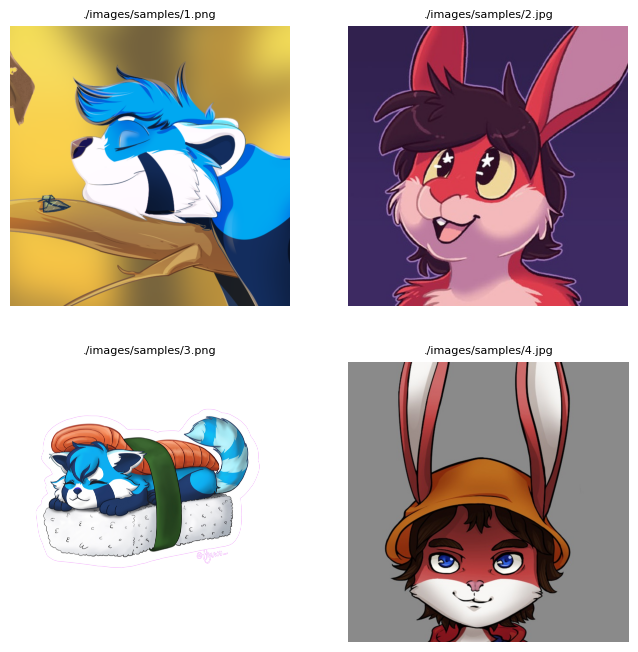

In [3]:
# Helper function for showing the images
def show_images(image_paths: list, labels: list = None, n_imgs: int = 4, n_cols: int = 2):
    n_rows = n_imgs // n_cols
    style.use('default')
    plt.figure(figsize=(8, 4*n_rows))

    for i in range(n_rows*n_cols):
        image = image_paths[i]
        img = Image.open(image)
        
        ax = plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        if labels:
            label_text = [str(l) for l in labels[i]]
            label_text = ', '.join(label_text)
            plt.title(f'{image}\n{label_text}', size=8)
        else:
            plt.title(image, size=8)
            
        plt.axis('off')

# Get image paths
sample_dir = './images/samples/'
images = os.listdir(sample_dir)
image_paths = [os.path.join(sample_dir, image) for image in images]

show_images(image_paths)

### Predicting Labels

Now that we have seen our images, let's see how we can use the model to predict the tags in each image.

In [4]:
# Use the furry model to predict the labels
image_labels = furry_model.predict_image_tags(*image_paths, return_values=False)

for label in image_labels:
    print(label)

1/1 [==============================] - 1s 1s/step
['male', 'anthro', 'fur', 'safe']
['fur', 'hair', 'safe']
['ailurid', 'fur', 'safe']
['lagomorph', 'anthro', 'fur', 'looking_at_viewer', 'smile', 'safe']
['male', 'anthro', 'fur', 'hair', 'eyewear', 'smile', 'safe']
['fur', 'safe']
['male', 'anthro', 'clothed', 'fur', 'hair', 'eyewear', 'topwear', 'smile', 'safe']
['male', 'anthro', 'fur', 'hair', 'teeth', 'looking_at_viewer', 'open_mouth', 'smile', 'safe']


Wow! It's really that easy! Now, let's compare side by side.

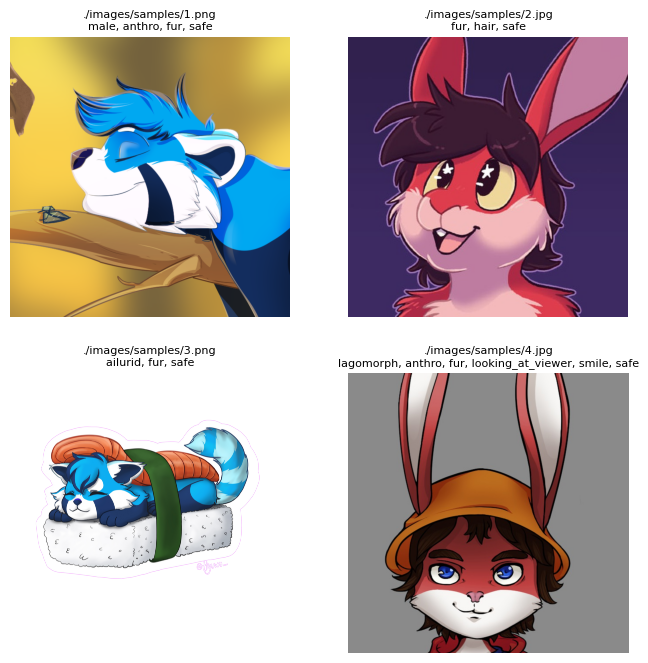

In [5]:
show_images(image_paths, image_labels)

### Other Uses
There are some other things you can also adjust when running the tagging model. You can adjust the threshold for accepting a tag, whether or not you want the value for each tag returned, and finally whether or not you want all the tags concatenated together. Let's see these in action below:

1/1 [==============================] - 1s 865ms/step


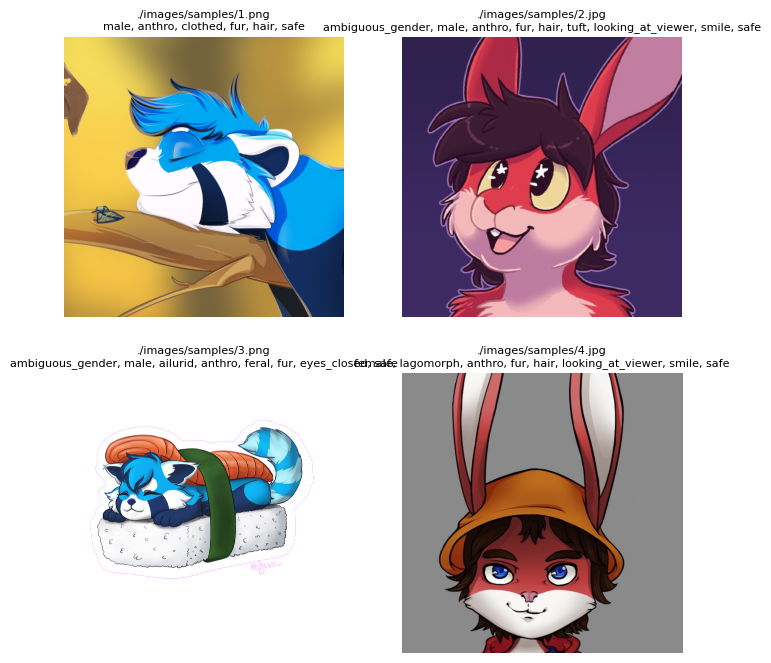

In [6]:
# Lowering the threshold for the tags
image_labels = furry_model.predict_image_tags(*image_paths, t=0.35, return_values=False)
show_images(image_paths, image_labels)

1/1 [==============================] - 1s 755ms/step


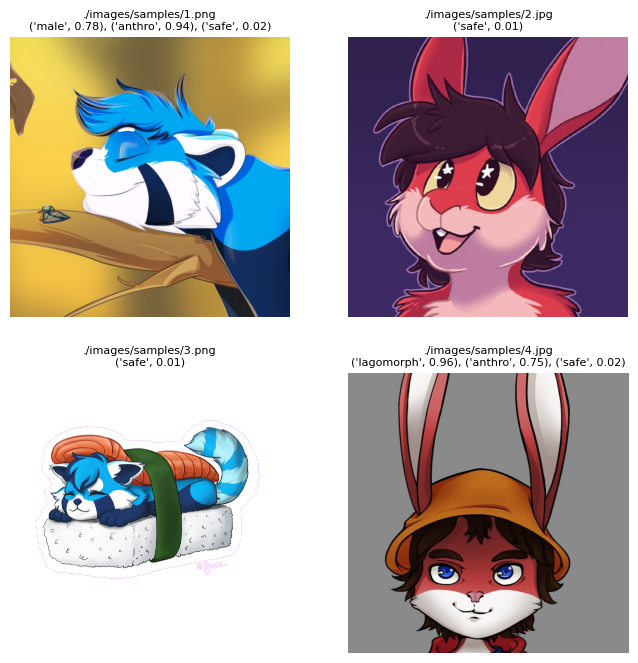

In [7]:
# Showing the confidence of each tag
image_labels = furry_model.predict_image_tags(*image_paths, t=0.7)

# Rounding the values returned for clarity's sake
image_labels = [[(l[0], round(l[1], 2)) for l in label_lst] for label_lst in image_labels]

show_images(image_paths, image_labels)

1/1 [==============================] - 1s 641ms/step


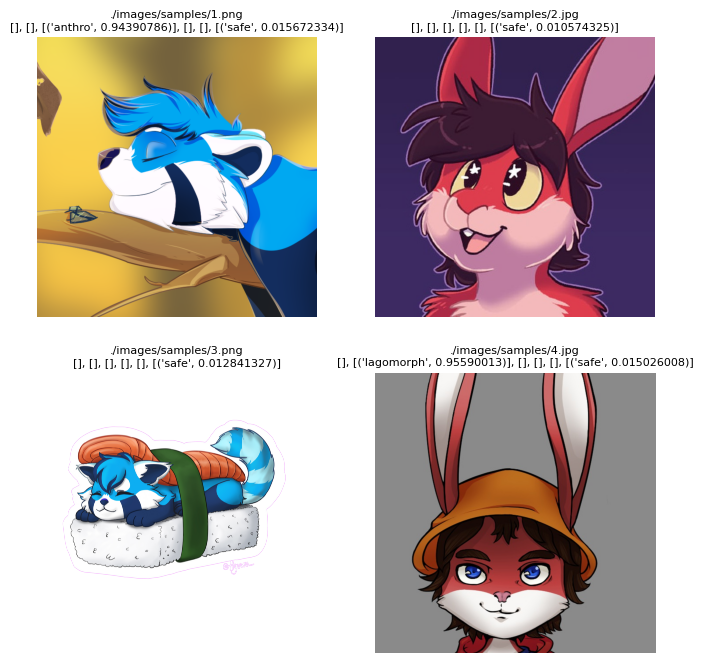

In [8]:
# Stop the tags from being concatenated all together
image_labels = furry_model.predict_image_tags(*image_paths, t=0.9, return_concat=False)

show_images(image_paths, image_labels)

### Summary

Honestly, if you would really like a more robust method of using this model for tagging, I would suggest taking a peek under the hood in `./model.py`. My code is moreso for showing how the model can potentially be used. That being said, here are some patterns I have recognized for using it:

- **ALWAYS HANDLE RATING WITH SEPARATE LOGIC.**
  - The meaning of it's returned value is completely different from the rest of the outputs since it's a rating scale.
  - Sorting the returned tags by probability is slightly nonsensical when also including rating (highly confident `safe` posts get the safe rating put all the way at the end).
- Be very cautious with modifying rating boundaries.
  - More often then not, you will end up having more problems with this, unless your usecase is really sensitive to adult rated content sneaking through, or vice-versa.
- Use `t=0.0` and `return_values=True` for a full list of proabilities if you would like to handle this logic yourself.
  - Related, you can access the variable `furry_model.layer_order` to see in what order the tag categories are being outputted.

Other then that, you should be good to go on using this model yourself to tag images!


# Encoding Images

One really neat thing about this model is that the feature layer's output acts like an extremly dense vector representation of the image. Essentially, We have crushed an (N,N,3) image down into a (D,) vector. For instance, with `./models/effnet_b3_300_2c`, it takes a (300,300,3) image and compresses it down into a (1536,) length vector, reducing the size of the encoded information by ~99.43%! This dimensonality reduction from the feature layer has encoded the "important" information from the image, the information that is relavent to answering the questions our prediction heads are asking.

In less math-y terms, this means we can describe images in a way that is very succinct for computers to understand, but also allow us to do some pretty neat comparisons. Let's see this in action.

In [9]:
# Load default furry image model
furry_model = FurryImageModel('./models/effnet_b3_300_2c')

### Generating Feature Vectors

Now, we're going to generate the feature vectors for each image

(Note: The code blocks below are expeting you to have ran all the previous code cells in the "Tagging Images" section above)

In [10]:
# Use the furry model to predict the labels
feature_vectors = furry_model.image_latent_vector(*image_paths)

feature_vectors

1/1 [==============================] - 2s 2s/step


array([[-0.12818044,  0.40441242, -0.05303227, ..., -0.1951054 ,
        -0.1964278 , -0.19788407],
       [-0.13228898, -0.09459502,  0.07998989, ..., -0.03494512,
        -0.18111312, -0.18532768],
       [-0.15377611,  0.741269  ,  0.13869226, ...,  0.14376393,
        -0.19298619, -0.19523811],
       ...,
       [-0.12384169, -0.08186449,  0.05005844, ..., -0.02391579,
        -0.18084027, -0.14661235],
       [-0.05007364,  0.28683004,  0.11058125, ..., -0.10361399,
        -0.12034641, -0.17093858],
       [-0.15702716, -0.06747858,  0.18620506, ..., -0.04848702,
        -0.14040871, -0.17305662]], dtype=float32)

Again, it's that easy! I know the that the output is a little rough to read, but let's do some Machine Learning magic to make the vectors a bit more human readable.

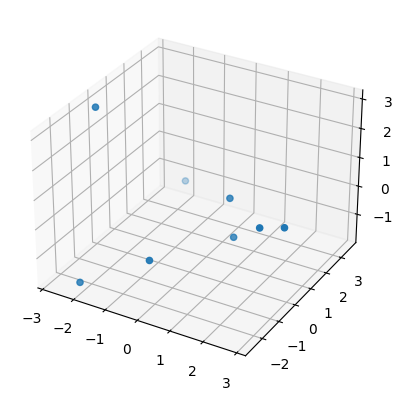

In [11]:
# Run Principal Component Analysis (PCA) to capture n=3 dimensions with the greatest variability
pca = PCA(n_components=3)
feature_vectors = pca.fit_transform(feature_vectors)

# Display vectors with reduced dimensionality
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(feature_vectors[:, 0], feature_vectors[:, 1], feature_vectors[:, 2])

plt.show()

### Clustering Images Using Latent Space

Wow! We can now visualize this weird, abstract space of how the images relate to each other... Let's see how these image cluster together.

In [12]:
n_clusters = 2

# Use a Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_clusters, random_state=32)
gmm.fit(feature_vectors)
cluster = gmm.predict(feature_vectors)

cluster

array([0, 1, 1, 1, 0, 1, 0, 1], dtype=int64)

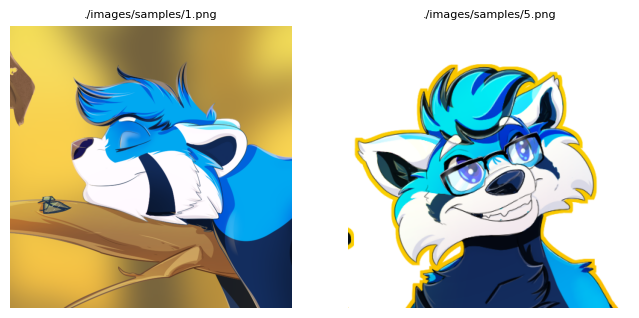

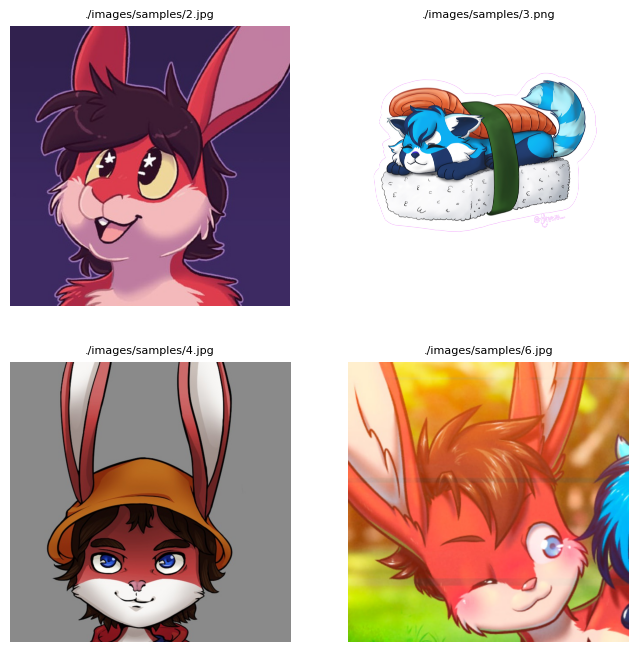

In [13]:
# Visualize the clusters
for i in range(n_clusters):
    indicies = set(np.where(cluster == i)[0])
    cluster_images = [image for j, image in enumerate(image_paths) if j in indicies]
    
    show_images(cluster_images, n_imgs=len(indicies))

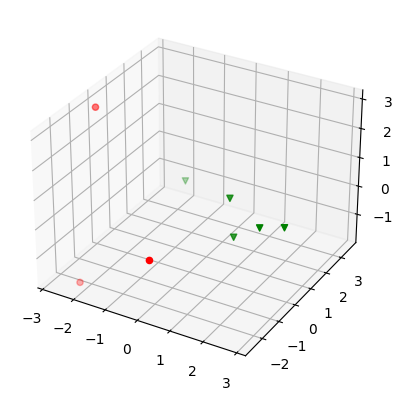

In [14]:
# Show the PCA projection based on cluster
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

color, marker = ['red','green','blue','magenta'], ['o', 'v', '^', 's']
for i in range(n_clusters):
    indicies = np.where(cluster == i)[0]
    clst = feature_vectors[indicies]
    ax.scatter(clst[:, 0], clst[:, 1], clst[:, 2], color=color[i], marker=marker[i])
    
plt.show()

Using unsupervised learning methods, we can start grouping similar artwork in ways that have not been possible before.

**NOTE:** Ok so obviously this example is flawed; separating predominantly blue and red images is a very simple task. In fact, using my original samples, we can see it sometimes doesn't cluster in a way we expect due to the sparseness. However, I impore you to try your own samples with this model! Try seeing if it can separate more abstract concepts, like artwork containing eye glasses, or seeing if it clusters gender/identity differently. You will be surprised by what it can and cannot do!

### Summary

Using the latent vector of an image is an incredibly powerful tool! It's as if we have a semantic representation of the contents of the image for computers. It can be used for things like unsupervised clustering of images for finding similar images (think recommendation systems), or it could be used for creating your own fine-tuned model (think a classifier for "art I like"). These are fun projects I have been considering myself for using this project with.

Like the previous summary, I will write a few pointers on things I have learned while using it.

- The most obvious distinction PCA shows is separating safe artwork and adult artwork.
  - Referring back to the tagging portion of the model, typically, NSFW artwork contains a different subset of tags, so this makes sense.
- Low sample sizes (<40) fail to capture the full dimensionality of the latent vector space (especially with PCA). It will tend to incorrectly cluster because of this.

Overall, I believe that the latent space representation is an incredibly more powerful/useful tool than the tagging model. Being able to represent artwork in this way opens up many, many avenues for highly specialized models that were previously not possible due to data limitations. See what you can do with this!

# Writing a Custom Model Interface

I am going to keep this section very brief, because at this point, it would be teaching TensorFlow, which is outside the depth of this notebook. However, I will still provide some more context on the how to use this weird model architecture in your own use cases.

First, let's start with explaining the architecture of this model again.

![effnet_b3_300_2c](./images/readme/model_architecture.png)

The model starts with an imput layer which takes a batch of images and passes it through a KerasLayer. The KerasLayer is a TFHub pretrained model that had finetuning enabled during training on the furry artwork. In the case of this image (and the rest of this notebook), it is the [efficientnet_v2_imagemnet1k_b3](https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2) model. From here, the model was created using the [Functional API for TensorFlow](https://www.tensorflow.org/guide/keras/functional_api) in order to pass the feature layer into every prediction head. Each prediction head has a hidden layer of 128 nodes and a softmax output for the number of outputs each category.

The model was designed this way because it allowed me to specify specific loss functions for each prediction head. It also allowed me to specify a weight for each loss function while training. Essentially, this allowed me to finetune each prediction head to its own dataset while not affecting the other prediction heads during backpropogation. That is all the detail I am going to go into here, I will have more info on my process in the [README](./README.md).

Another thing to note for using models I create is that I use the TensorFlow [SavedModel format](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format). It makes everything easier, especially when using custom layers/loss functions (which is something I plan to do in the future).

Knowing this, we can pick and choose what we want to output as our result. Let's see this in action.

In [15]:
model_path = 'models/effnet_b3_300_2c/'

#Load the SavedModel format
default_model = tf.keras.models.load_model(model_path)
default_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input (InputLayer)      [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 feature_layer (KerasLayer)  (None, 1536)                 1293062   ['img_input[0][0]']           
                                                          2                                       
                                                                                                  
 identity_hidden_layer (Den  (None, 128)                  196736    ['feature_layer[0][0]']       
 se)                                                                                              
                                                                                              

In [16]:
input_layer = default_model.get_layer('img_input')
hidden_layer = default_model.get_layer('species_hidden_layer')
new_model = tf.keras.Model(inputs=input_layer.input, outputs=hidden_layer.output)

new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 300, 300, 3)]     0         
                                                                 
 feature_layer (KerasLayer)  (None, 1536)              12930622  
                                                                 
 species_hidden_layer (Dens  (None, 128)               196736    
 e)                                                              
                                                                 
Total params: 13127358 (50.08 MB)
Trainable params: 13018142 (49.66 MB)
Non-trainable params: 109216 (426.62 KB)
_________________________________________________________________


Just like the previous section on latent vectors, we just made one specifically for the species hidden layer! Extending this further, you can switch up the final output layer(s) to get a highly customized model. Maybe you just want the rating? Then you can isolate the rating prediction head! Want just the species and body outputs, well you can do that as well! That is one very powerful aspect of the Functional API for TensorFlow. Just for fun, let's see what it does.

1/1 [==============================] - 2s 2s/step
Image: ./images/samples/1.png Cluster: 0
Image: ./images/samples/3.png Cluster: 0
Image: ./images/samples/5.png Cluster: 0
Image: ./images/samples/7.png Cluster: 0
Image: ./images/samples/2.jpg Cluster: 1
Image: ./images/samples/4.jpg Cluster: 1
Image: ./images/samples/6.jpg Cluster: 1
Image: ./images/samples/8.jpg Cluster: 1


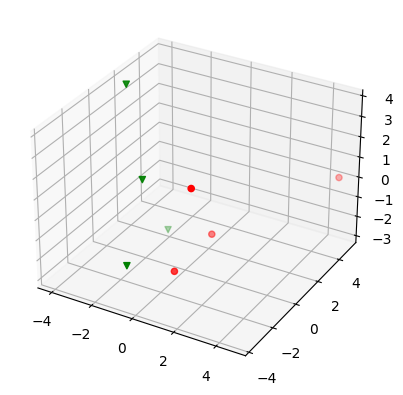

In [17]:
# I am doing this for simplicity's sake since the FurryImageModel class already does the
# hard work for executing this model. Also yes I am copying all the code I wrote previously.
furry_model.feature_model = new_model
res = furry_model.image_latent_vector(*image_paths)

# Run Principal Component Analysis (PCA) to capture n=3 dimensions with the greatest variability
pca = PCA(n_components=3)
res = pca.fit_transform(res)

# Use a Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_clusters, random_state=128)
gmm.fit(res)
cluster = gmm.predict(res)

# Show the PCA projection based on cluster
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

color, marker = ['red','green','blue','magenta'], ['o', 'v', '^', 's']
for i in range(n_clusters):
    indicies = np.where(cluster == i)[0]
    for j in indicies:
        print(f'Image: {image_paths[j]} Cluster: {i}')
    clst = res[indicies]
    ax.scatter(clst[:, 0], clst[:, 1], clst[:, 2], color=color[i], marker=marker[i])

plt.show()

Again, like in the previous section, the more data you have, the better it is for visualizing these latent spaces. Honestly, when running through this notebook, I was almost surprised that the PCA space looks almost exactly the same!

Regardless, This should give you an idea on how you can create your own custom models! I would also definitely recommend looking at `./model.py` for more insight. I'm not great at writing code for TensorFlow, but it's a good start!

# Conclusion

Hopefully this notebook was a good guide on how to use the furry image model! This project is still very much a work in progress, so expect it to be changing quite a bit throughout 2023 and maybe into 2024. If you have any questions or concerns, please reach out to me at zenith@pawgge.rs or [@zenithO_o](https://twitter.com/zenithO_o) on Twitter.